## Classification of Fruits And Vegetables

In [ ]:
# !pip install kaggle

# !mkdir .kaggle

# import json
# token = {"username":"ivyclare","key":"17ee8bd3b41486d62e7eb9257bd812d4"}
# with open('/content/.kaggle/kaggle.json', 'w') as file:
#     json.dump(token, file)

# !chmod 600 /content/.kaggle/kaggle.json

# !cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json


# !kaggle config set -n path -v{/content}

# #!kaggle datasets download -d shayanfazeli/heartbeat -p /content
# !kaggle datasets download -d moltean/fruits -p /content
# !unzip \*.zip

### Import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import torch
from torchvision import datasets,transforms,models
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import *

import time
import json
import copy
import os
import glob

from PIL import Image


# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### Load And Visualize Data

Given the data is to
The image data for this competition are too large to fit in memory in kernels. This kernel demonstrates how to access individual images in the zip archives without having to extract them or load the archive into memory.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os

# Specify the path to the zip file
zip_file_path = '/content/drive/MyDrive/fruits.zip'

# Specify the extraction path
extract_path = '/content/MY_data'

# Extract the contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify extraction
os.listdir(extract_path)

['MY_data']

In [4]:
#Now we load images and labels from folder into pytorch tensor
data_dir = 'MY_data'
train_dir = 'MY_data/MY_data/train'
test_dir = 'MY_data/MY_data/test'
batch_size = 32

# Tansform with data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        #transforms.RandomResizedCrop(224),
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'predict': transforms.Compose([
        transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
        transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
}


dataset = datasets.ImageFolder(train_dir,transform=data_transforms['train'])
# splitting our data
valid_size  = int(0.2 * len(dataset))
train_size = len(dataset) - valid_size
dataset_sizes = {'train': train_size, 'predict': valid_size}

# now we get our datasets
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

test_dataset = datasets.ImageFolder(test_dir,transform=data_transforms['test'])

# Loading datasets into dataloader
dataloaders = {'train': DataLoader(train_dataset, batch_size = batch_size, shuffle = True),
              'predict': DataLoader(valid_dataset, batch_size = batch_size, shuffle = False),
              'test': DataLoader(test_dataset, batch_size = batch_size, shuffle = False)}

print("Total Number of Samples: ",len(dataset))
print("Total citra untuk Train: ",len(train_dataset))
print("Number of Samples in Valid: ",len(valid_dataset))
print("Number of Samples in Test: ",len(test_dataset))
print("Number of Classes: ",len(dataset.classes))


Total Number of Samples:  2301
Total citra untuk Train:  1841
Number of Samples in Valid:  460
Number of Samples in Test:  1025
Number of Classes:  10


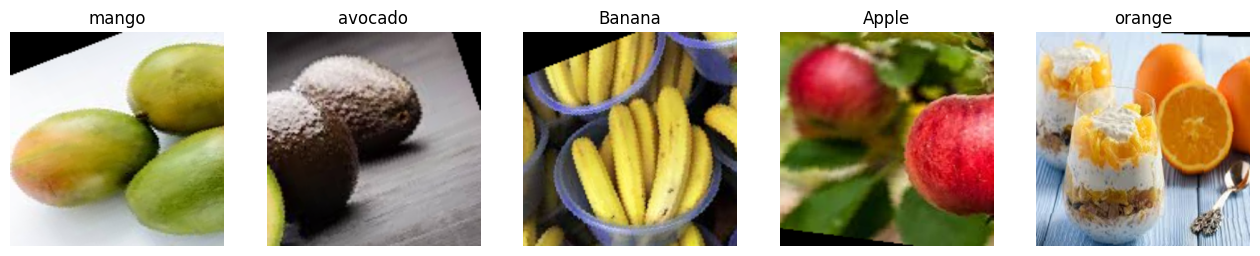

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    if title is not None:
        ax.set_title(title)

    return ax

# Get the original dataset from the Subset object
original_dataset = dataloaders['train'].dataset.dataset
class_names = original_dataset.classes
label_map = {idx: class_name for idx, class_name in enumerate(class_names)}

# Displaying Training Images
images, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(figsize=(16, 5), ncols=5)
for ii in range(5):
    ax = axes[ii]
    label = labels[ii].item()
    title = label_map[label]
    imshow(images[ii], ax=ax, normalize=True, title=title)

plt.show()

### Building MLP Network

### Transfer Learning

### Load Pretrained Model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = 'resnet' #vgg
if model_name == 'densenet':
    model = models.densenet161(pretrained=True)
    num_in_features = 2208
    print(model)
elif model_name == 'vgg':
    model = models.vgg19(pretrained=True)
    num_in_features = 25088
    print(model.classifier)
elif model_name == 'resnet':
    model = models.resnet152(pretrained=True)
    #model = models.resnet34(pretrained=True)
    num_in_features = 2048 #512
    print(model.fc)
elif model_name == 'inception':
    model = models.inception_v3(pretrained=True)
    model.aux_logits=False
    num_in_features = 2048
    print(model.fc)
else:
    print("Unknown model, please choose 'densenet' or 'vgg'")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 188MB/s]


Linear(in_features=2048, out_features=1000, bias=True)


### Freeze Parameters and Build Classifier

In [7]:
#Freezing model parameters and defining the fully connected network to be attached to the model, loss function and the optimizer.
#We there after put the model on the GPUs
for param in model.parameters():
    param.require_grad = False

# Create Custom Classifier
def build_classifier(num_in_features, hidden_layers, num_out_features):

    classifier = nn.Sequential()
    if hidden_layers == None:

        classifier.add_module('fc0', nn.Linear(num_in_features, 196))

    else:

        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        classifier.add_module('fc0', nn.Linear(num_in_features, hidden_layers[0]))
        classifier.add_module('relu0', nn.ReLU())
        classifier.add_module('drop0', nn.Dropout(.6))

#         classifier.add_module('relu1', nn.ReLU())
#         classifier.add_module('drop1', nn.Dropout(.5))

        for i, (h1, h2) in enumerate(layer_sizes):
            classifier.add_module('fc'+str(i+1), nn.Linear(h1, h2))
            classifier.add_module('relu'+str(i+1), nn.ReLU())
            classifier.add_module('drop'+str(i+1), nn.Dropout(.5))
        classifier.add_module('output', nn.Linear(hidden_layers[-1], num_out_features))

    return classifier

In [8]:
hidden_layers = None #[1050 , 500] #[4096, 1024] #None#[4096, 1024, 256][512, 256, 128] [1050 , 500]

classifier = build_classifier(num_in_features, hidden_layers, 196)
print(classifier)

 # Defining model hyperparameters
if model_name == 'densenet':
    model.classifier = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adadelta(model.parameters()) # Adadelta #weight optim.Adam(model.parameters(), lr=0.001, momentum=0.9)
    #optimizer_conv = optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.001, momentum=0.9)
   # Decay LR by a factor of 0.1 every 4 epochs
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4)
elif model_name == 'vgg':
    model.classifier = classifier
    #criterion = nn.NLLLoss()
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(model.parameters(), lr=0.0001,weight_decay=0.001, momentum=0.9)
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
elif model_name == 'resnet':
    model.fc = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
  #sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

#     #criterion = nn.NLLLoss()
#     optimizer = optim.Adam(model.fc.parameters(), lr= 0.00001)
#     sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
#criterion = nn.CrossEntropyLoss()

elif model_name == 'inception':
    model.fc = classifier
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adadelta(model.parameters()) # Adadelta #weight optim.Adam(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
else:
    pass

Sequential(
  (fc0): Linear(in_features=2048, out_features=196, bias=True)
)


### Training The Model

In [9]:
import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, sched, num_epochs=5, device='cuda'):
    start = time.time()
    train_results = {'loss': [], 'acc': []}
    valid_results = {'loss': [], 'acc': []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'predict']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_results['loss'].append(epoch_loss)
                train_results['acc'].append(epoch_acc)
            else:
                valid_results['loss'].append(epoch_loss)
                valid_results['acc'].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model (Early Stopping) and Saving our model, when we get best accuracy
            if phase == 'predict' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                model_save_name = "FruitInception.pt"
                path = F"/content/drive/MyDrive/{model_save_name}"
                torch.save(model.state_dict(), path)

        print()

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)



    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_results['loss'], label='Train Loss')
    plt.plot(range(1, num_epochs + 1), valid_results['loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    print(train_results['acc'], valid_results['acc'])

    train_results['acc'] = [value.cpu() for value in train_results['acc']]
    valid_results['acc'] = [value.cpu() for value in valid_results['acc']]

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_results['acc'], label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), valid_results['acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    return model, train_results, valid_results


Epoch 1/3
----------
train Loss: 1.2113 Acc: 0.6665
predict Loss: 1.6885 Acc: 0.5913

Epoch 2/3
----------
train Loss: 0.7163 Acc: 0.7757
predict Loss: 0.6390 Acc: 0.8152

Epoch 3/3
----------
train Loss: 0.5683 Acc: 0.8197
predict Loss: 0.4541 Acc: 0.8543

Training complete in 4m 43s
Best val Acc: 0.8543


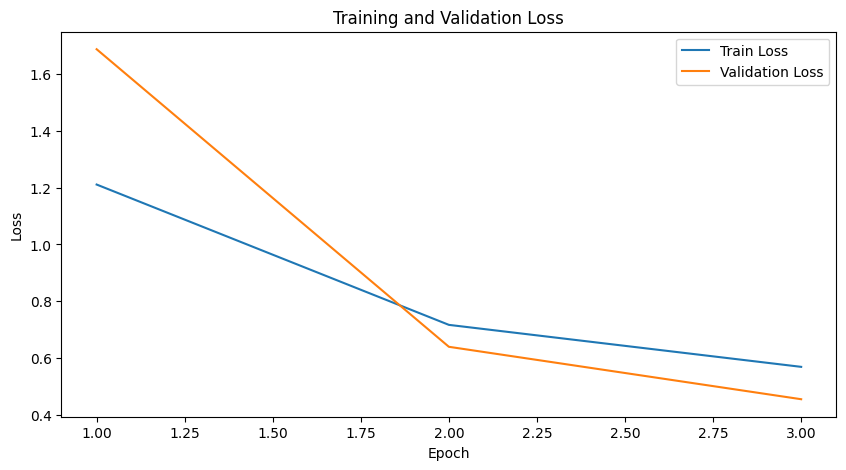

[tensor(0.6665, device='cuda:0', dtype=torch.float64), tensor(0.7757, device='cuda:0', dtype=torch.float64), tensor(0.8197, device='cuda:0', dtype=torch.float64)] [tensor(0.5913, device='cuda:0', dtype=torch.float64), tensor(0.8152, device='cuda:0', dtype=torch.float64), tensor(0.8543, device='cuda:0', dtype=torch.float64)]


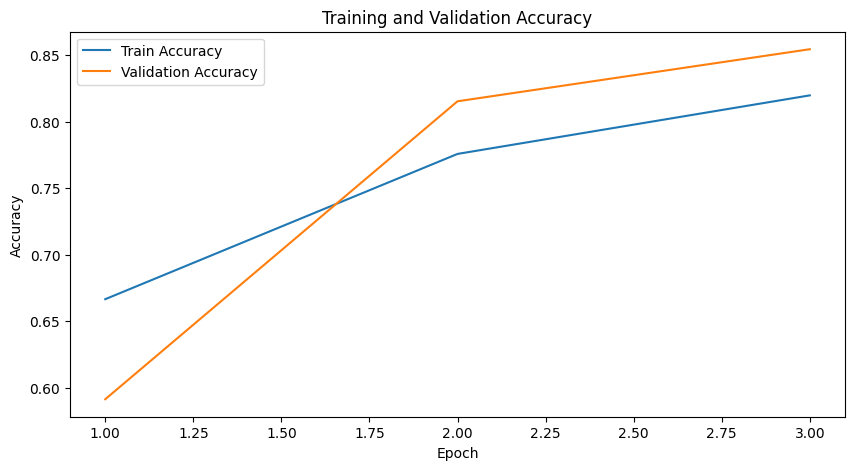

In [10]:
epochs = 3
model.to(device)
model,train_results,valid_results = train_model(model, criterion, optimizer, sched, epochs)



In [11]:
features = []
labels = []
with torch.no_grad():
    for inputs, label in dataloaders["train"]:
        inputs = inputs.to(device)
        outputs = model(inputs)
        features.append(outputs.cpu())
        labels.append(label)

features = torch.cat(features)
labels = torch.cat(labels)


In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np


# Standardize features and train KNN
scaler = StandardScaler()
knn = KNeighborsClassifier(n_neighbors=10)
pipeline = make_pipeline(scaler, knn)

pipeline.fit(features, labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=10))])

In [13]:
def evaluate_knn(model, pipeline, dataloaders, device='cuda'):
    model.eval()
    val_features = []
    val_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['predict']:
            inputs = inputs.to(device)
            outputs = model(inputs)
            val_features.append(outputs.cpu().numpy())
            val_labels.append(labels.cpu().numpy())

    val_features = np.concatenate(val_features, axis=0)
    val_labels = np.concatenate(val_labels, axis=0)

    val_acc = pipeline.score(val_features, val_labels)

    return val_acc

# Evaluate
val_acc = evaluate_knn(model, pipeline, dataloaders)
print(f'Validation Accuracy: {val_acc:.4f}')

Validation Accuracy: 0.8739


### Check for Overfitting

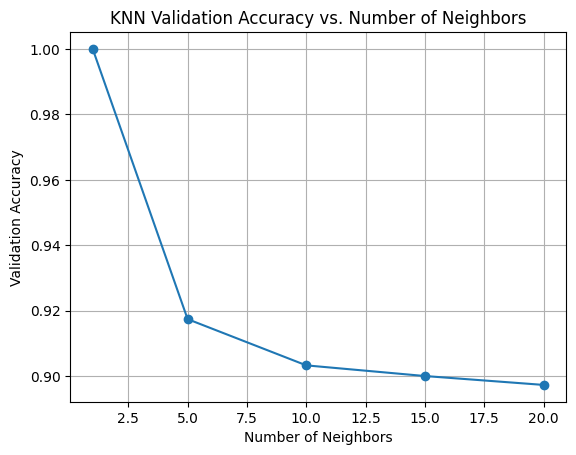

In [14]:
import matplotlib.pyplot as plt

# Define a function to train and evaluate KNN with different numbers of neighbors
def train_and_evaluate_knn(n_neighbors_list, features, labels):
    accuracies = []
    for n_neighbors in n_neighbors_list:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        pipeline = make_pipeline(scaler, knn)
        pipeline.fit(features, labels)
        val_acc = pipeline.score(features, labels)
        accuracies.append(val_acc)
    return accuracies

# Define a list of numbers of neighbors to try
n_neighbors_list = [1, 5, 10, 15, 20]

# Train and evaluate KNN for different numbers of neighbors
accuracies = train_and_evaluate_knn(n_neighbors_list, features, labels)

# Visualize the accuracy
plt.plot(n_neighbors_list, accuracies, marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('Validation Accuracy')
plt.title('KNN Validation Accuracy vs. Number of Neighbors')
plt.grid(True)
plt.show()

In [15]:
from joblib import dump


# Export the trained KNN model
dump(pipeline, '/content/drive/MyDrive/knn_model.joblib')


['/content/drive/MyDrive/knn_model.joblib']

In [16]:
import pickle

# Save the model to a file
with open('extractor.pkl', 'wb') as file:
    pickle.dump(model, file)

### Load Saved Model

In [17]:
from joblib import load

# Load the trained KNN model
loaded_model = load('/content/drive/MyDrive/knn_model.joblib')

In [18]:
import pickle

# Load the model from the file
with open('extractor.pkl', 'rb') as file:
    model = pickle.load(file)


### Testing The Model

#### Test Model Per Class

### Test With Single Image

Predicted class: watermelon


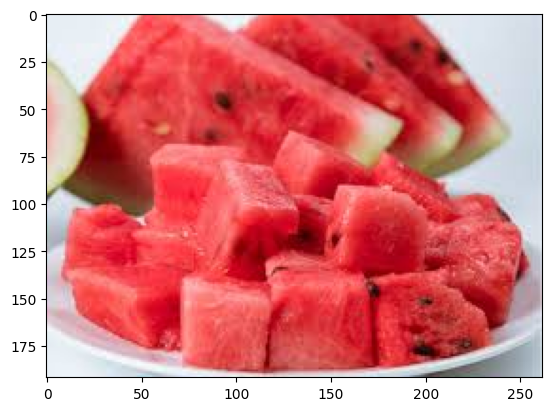

In [19]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def test_with_single_image(model, knn_pipeline, file, transform, classes):
    file = Image.open(file).convert('RGB')

    img = transform(file).unsqueeze(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        out = model(img.to(device))
        features = out.cpu().numpy()
        prediction = knn_pipeline.predict(features)
        predicted_class = classes[prediction[0]]

        print("Predicted class:", predicted_class)

        plt.imshow(np.array(file))
        plt.show()

test_with_single_image(model, loaded_model, '/content/MY_data/MY_data/predict/012.jpeg', data_transforms['test'], dataset.classes)


Predicted class: mango


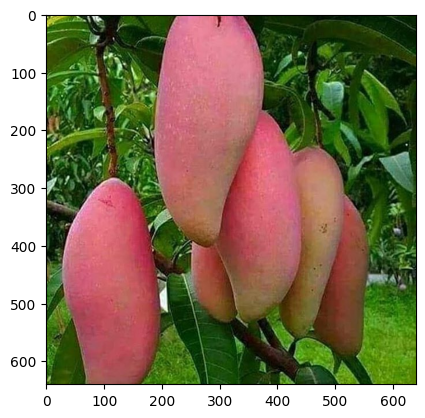

In [20]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

def test_with_single_image_url(model, knn_pipeline, url, transform, classes):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')

    img_transformed = transform(img).unsqueeze(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        out = model(img_transformed.to(device))
        features = out.cpu().numpy()
        prediction = knn_pipeline.predict(features)
        predicted_class = classes[prediction[0]]

        print("Predicted class:", predicted_class)

        plt.imshow(np.array(img))
        plt.show()

test_with_single_image_url(model, loaded_model, 'https://pbh.pertanian.jatimprov.go.id/wp-content/uploads/2020/12/bibit-mangga-red-ivory-tm.jpg', data_transforms['test'], dataset.classes)

In [21]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


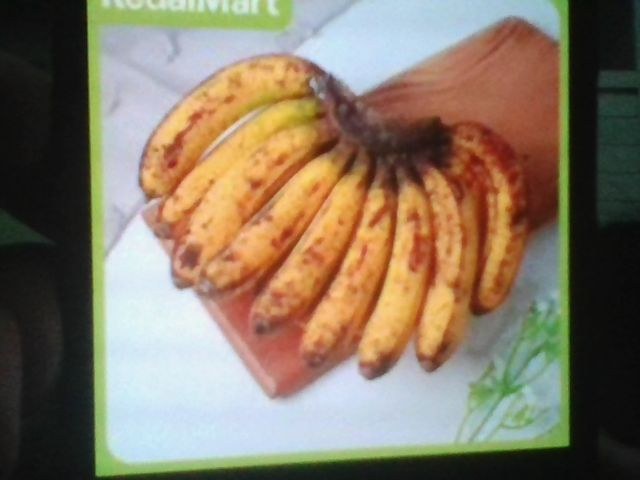

In [22]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Predicted class: Banana


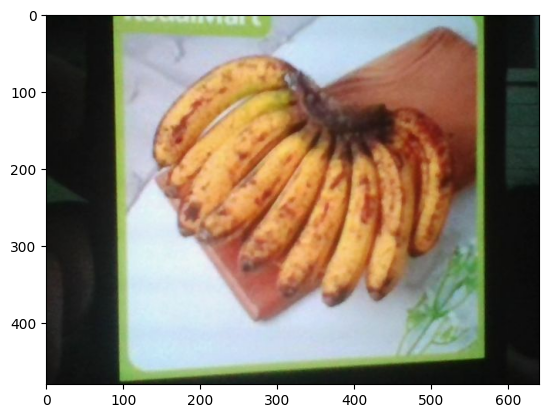

In [23]:
from PIL import Image
test_with_single_image(model, loaded_model, '/content/photo.jpg', data_transforms['test'], dataset.classes)